In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db= mysql.connector.connect(host= 'localhost', username= 'root', password= '1234',database='Ecommerce')
cur= db.cursor()


# List all unique cities where cutomers are located

In [21]:
query= """ SELECT DISTINCT customer_city FROM customers;"""


cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data,columns=["City"])
df.head(10)

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# Count the number of orders placed in 2017.

In [22]:
query= """SELECT COUNT(order_id) FROM orders
WHERE YEAR(order_purchase_timestamp)= 2017;"""


cur.execute(query)
data= cur.fetchall()
data[0][0]

45101

# Find the total sales per category.

In [23]:
query= """SELECT products.product_category, round(sum(payments.payment_value),2) AS sales
FROM products
JOIN order_items
ON products.product_id= order_items.product_id
join payments ON payments.order_id = order_items.order_id
GROUP BY products.product_category
ORDER BY sales DESC;"""


cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns=['Category','Sales'])
df
                 

,Category,Sales
0,bed table bath,1712553.67
1,HEALTH BEAUTY,1657373.12
2,computer accessories,1585330.45
3,Furniture Decoration,1430176.39
4,Watches present,1429216.68
...,...,...
69,PC Gamer,2174.43
70,House Comfort 2,1710.54
71,cds music dvds,1199.43
72,Fashion Children's Clothing,785.67


 # Calculate the percentage of orders that were paid in installments.

In [24]:
query="""SELECT sum(
(CASE
WHEN payments.payment_installments >=1 THEN 1
Else 0
END)) / count(payments.payment_installments)*100 AS Percentage_installment_order FROM payments;"""


cur.execute(query)
data= cur.fetchall()
data

[(Decimal('99.9981'),)]

# Count the number of customers from each state. 

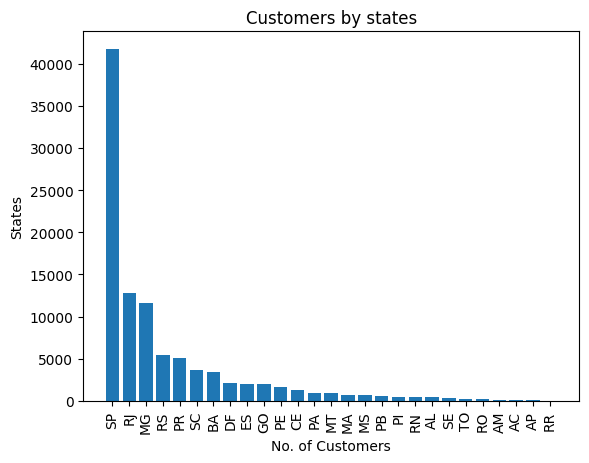

<Figure size 500x200 with 0 Axes>

In [25]:
query= """SELECT COUNT(Customer_id) AS customers_count, customer_state FROM customers
GROUP BY customer_state
ORDER BY customers_count DESC;"""


cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns= ["Customer_count","State"])
df= df.sort_values(by = "Customer_count", ascending = False)
plt.bar(df["State"], df["Customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("No. of Customers")
plt.ylabel("States")
plt.title("Customers by states")
plt.figure(figsize = (5,2))

plt.show()

 # Calculate the number of orders per month in 2018.

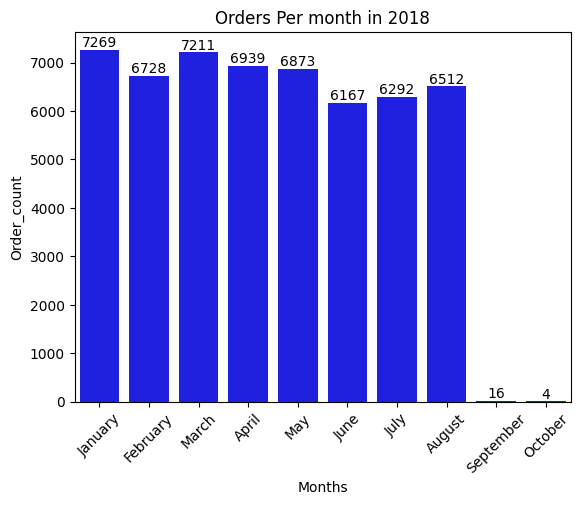

In [37]:
query= """SELECT YEAR(order_purchase_timestamp) AS YEAR, MONTHNAME(order_purchase_timestamp) AS MONTH,COUNT(order_id) AS COUNT FROM orders
WHERE order_purchase_timestamp = 2018
GROUP BY YEAR(order_purchase_timestamp), MONTHNAME(order_purchase_timestamp)
ORDER BY MONTH(order_purchase_timestamp);"""


cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns= [ "Years","Months", "Order_count"])
o= ["January", "February", "March", "April", "May", "June", "July", "August", "September","October"]
ax =sns.barplot(data= df, x=df["Months"], y=df["Order_count"],order=o,color="blue") #hue= df["Months"],palette="viridis"
plt.xticks(rotation= 45)
ax.bar_label(ax.containers[0])
plt.title("Orders Per month in 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [27]:
query= """WITH count_per_order AS(SELECT orders.order_id, orders.customer_id, COUNT(order_items.product_id) AS order_count
FROM orders
JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, AVG(count_per_order.order_count) FROM customers
JOIN  count_per_order
ON customers.customer_id= count_per_order.customer_id
GROUP BY customers.customer_city
ORDER BY AVG(count_per_order.order_count) DESC;"""


cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns= ["City", "Average orders"])
df

,City,Average orders
0,padre carvalho,7.0000
1,celso ramos,6.5000
2,datas,6.0000
3,candido godoi,6.0000
4,matias olimpio,5.0000
...,...,...
4105,lagoa da canoa,1.0000
4106,japaratuba,1.0000
4107,sebastiao leal,1.0000
4108,morro agudo de goias,1.0000


# Calculate the percentage of total revenue contributed by each product category.

In [28]:
query= """SELECT products.product_category, ROUND((SUM(payment_value)/ (SELECT SUM(payment_value) FROM payments)*100),2) AS total_revenue FROM order_items
JOIN products
ON products.product_id= order_items.product_id
JOIN payments
ON order_items.order_id= payments.order_id
GROUP BY products.product_category
ORDER BY total_revenue DESC;"""


cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns= ["Products", "Sales in Percentage"])
df

,Products,Sales in Percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
...,...,...
69,House Comfort 2,0.01
70,cds music dvds,0.01
71,PC Gamer,0.01
72,Fashion Children's Clothing,0.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [29]:
query= """SELECT products.product_category, ROUND(AVG(order_items.price),2) avg_price, COUNT(order_items.product_id) order_frequency FROM products
JOIN order_items
ON products.product_id = order_items.product_id
GROUP BY products.product_category
ORDER BY  order_frequency DESC;"""


cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns= ["Product Category","No. of products sold", "Average product price"])
arr1= df["No. of products sold"]
arr2= df["Average product price"]
a= np.corrcoef([arr1, arr2])
print("Correlation b/w Order count and price",a[0][1])


Correlation b/w Order count and price -0.10631514167157564


# Calculate the total revenue generated by each seller, and rank them by revenue.

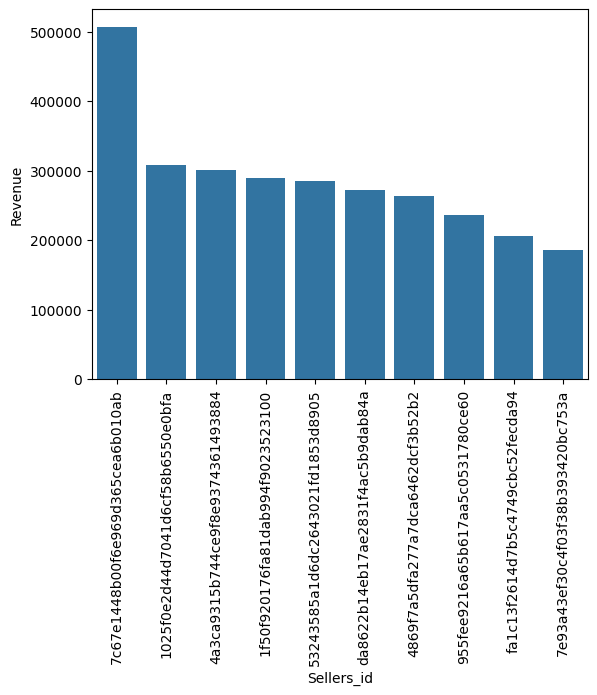

In [30]:
query= """SELECT *, RANK() OVER(ORDER BY sales DESC) AS seller_rank FROM
 (SELECT order_items.seller_id, ROUND(SUM(payments.payment_value),2)sales FROM order_items
JOIN payments
ON payments.order_id = order_items.order_id
GROUP BY order_items.seller_id) as revenue;"""


cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns= ["Sellers_id", "Revenue", "Rank"])
df= df.head(10)
sns.barplot(x= "Sellers_id", y= "Revenue", data= df)
plt.xticks(rotation= 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [31]:
query= """SELECT *, ROUND(AVG(customer_orders.order_value) OVER(PARTITION BY customer_orders.customer_id 
ORDER BY customer_orders.order_purchase_timestamp
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW),2) AS moving_avg 
FROM 
(SELECT orders.customer_id,
 orders.order_purchase_timestamp,payments.payment_value AS order_value 
 FROM orders
JOIN payments
ON payments.order_id = orders.order_id) AS customer_orders;"""


cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns= ["Customer_id", "Timestamp", "Payment_value","Moving_avg"])
df

,Customer_id,Timestamp,Payment_value,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


# Calculate the cumulative sales per month for each year.

In [33]:
query= """SELECT *, ROUND(SUM(sales) OVER(ORDER BY years, months),1) AS cumulative_sales
FROM
(SELECT YEAR(orders.order_purchase_timestamp) years, MONTH(orders.order_purchase_timestamp) months, ROUND(SUM(payments.payment_value),2) AS sales
FROM payments
JOIN orders
ON orders.order_id = payments.order_id 
GROUP BY years, months
ORDER BY years, months) as a;"""


cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns= ["Years", "Month No.","Payments","Cumulative_sales"])
df

,Years,Month No.,Payments,Cumulative_sales
0,2016,9,252.24,252.2
1,2016,10,59090.48,59342.7
2,2016,12,19.62,59362.3
3,2017,1,138488.04,197850.4
4,2017,2,291908.01,489758.4
5,2017,3,449863.60,939622.0
6,2017,4,417788.03,1357410.0
7,2017,5,592918.82,1950328.8
8,2017,6,511276.38,2461605.2
9,2017,7,592382.92,3053988.1


# Calculate the year-over-year growth rate of total sales.

In [29]:
query= """ WITH t As(SELECT YEAR(orders.order_purchase_timestamp) years, ROUND(SUM(payments.payment_value),2) Sales
FROM payments
JOIN orders
ON orders.order_id = payments.order_id
GROUP BY years
ORDER BY years)

SELECT *, ROUND((((Sales - LAG(sales,1) OVER(ORDER BY years))
/
LAG(sales,1) OVER(ORDER BY years))*100),2) 
FROM t;
"""

cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns= ["Years", "YOY_%"])
df

,Years,YOY_%
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [34]:
query= """WITH first_purchase AS 
 (SELECT orders.customer_id, MIN(orders.order_purchase_timestamp) as first_purchase_date
FROM orders
GROUP BY orders.customer_id),

second_purchase AS
(SELECT f.customer_id FROM first_purchase f
JOIN orders
ON f.customer_id = orders.customer_id
AND orders.order_purchase_timestamp > first_purchase_date
AND orders.order_purchase_timestamp <= DATE_ADD(first_purchase_date, INTERVAL 6 MONTH) 
GROUP BY f.customer_id)

SELECT (COUNT(DISTINCT s.customer_id) * 100.0 / COUNT(DISTINCT f.customer_id)) AS retention_rate
FROM first_purchase f
LEFT JOIN second_purchase s 
    ON f.customer_id = s.customer_id;"""

cur.execute(query)
data= cur.fetchall()
print("None of customer purchase anything in 6 months interval", data)

None of customer purchase anything in 6 months interval [(Decimal('0.00000'),)]


# Identify the top 3 customers who spent the most money in each year.

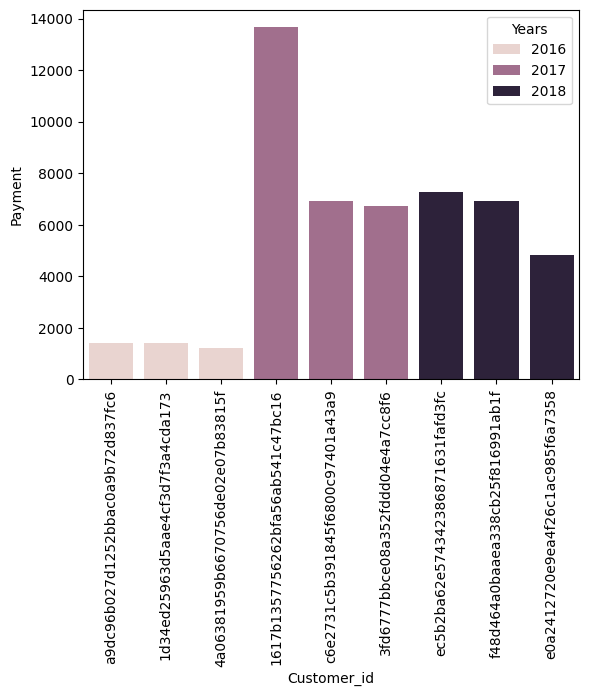

In [18]:
query= """SELECT a.years, a.customer_id, a.money_spent, a.d_rank
FROM
(SELECT orders.customer_id, 
YEAR(orders.order_purchase_timestamp) years,
ROUND(SUM(payments.payment_value),2) money_spent,
DENSE_RANK() OVER(PARTITION BY YEAR(orders.order_purchase_timestamp) ORDER BY SUM(payments.payment_value) DESC) AS d_rank
FROM orders
JOIN payments
ON payments.order_id= orders.order_id
GROUP BY years,orders.customer_id) as a
WHERE d_rank <=3 ;"""

cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data, columns=["Years","Customer_id","Payment","Rank"])
sns.barplot(x= "Customer_id", y="Payment", data= df, hue="Years")
plt.xticks(rotation = 90)
plt.show()
